In [63]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize the original image and its frequency spectrum (magnitude). Submit the images, and explanation.

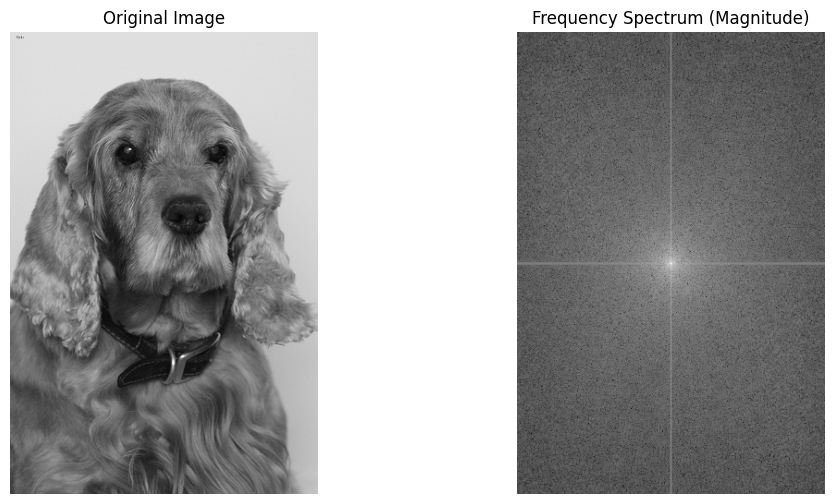

In [64]:
image_path = '../data/oxford-iiit-pet/images/english_cocker_spaniel_13.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the 2D Discrete Fourier Transform (DFT)
dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# Plot the original image and the magnitude spectrum
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum (Frequency Spectrum)
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Spectrum (Magnitude)')
plt.axis('off')

plt.show()

#  Implement a low-pass filter in the frequency domain to remove high-frequency noise from an image. Compare the filtered image with the original image. Submit images, and analysis of the results

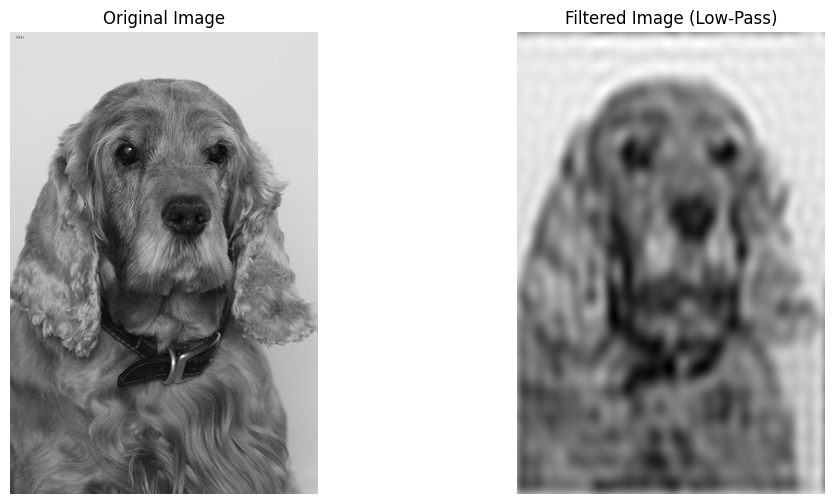

In [68]:
# Create a low-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2  # Center of the image
radius = 20  # Adjust radius as needed for filtering
mask = np.zeros((rows, cols, 2), np.uint8)
cv2.circle(mask, (ccol, crow), radius, (1, 1), thickness=-1)  # Create a circular mask

# Apply the mask to the DFT
filtered_dft_shift = dft_shift * mask

# Inverse DFT to get the filtered image
filtered_dft_shift_ishift = np.fft.ifftshift(filtered_dft_shift)
filtered_image = cv2.idft(filtered_dft_shift_ishift)
filtered_image_magnitude = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Plot the original image and the filtered image
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_magnitude, cmap='gray')
plt.title('Filtered Image (Low-Pass)')
plt.axis('off')

plt.show()


# Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image and discuss the effects observed. Submit images, and explanation.


# Implement an image compression technique using Fourier Transform by selectively keeping only a certain percentage of the Fourier coefficients. Evaluate the quality of the reconstructed image as you vary the percentage of coefficients used. Submit the images, and your observations on image quality and compression ratio.